# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv, conv_subspace
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [19]:
# Load from toy dataloader with two sessions
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/two_session_toy_dataloader.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/two_session_toy_dataloader.joblib'
cross_session_dataloader = joblib.load(data_path)

In [5]:
# Load from toy dataloader full of only 1 and 2
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/dummy_dataloader.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/dummy_dataloader.joblib'
dummy_dataloader = joblib.load(data_path)

# Train a model

In [6]:
data_to_use = dummy_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

torch.manual_seed(0)
np.random.seed(0)

params = {
    # B-spline basis
    'num_B_spline_basis': 5,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 16,
    'transformer_dropout': 0.0,
    'transformer_nhead': 2,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 4,
    'beta': 0.1,
    # Coupling's settings
    'coupling_basis_peaks_max': 20,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': None, 
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 5,
    'epoch_max': 50,
    'tol': 1e-6,
    # Currently not used
    'weight_decay': 0.0,
    'lr_transformer': 1e-2,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=True,
    fix_latents=True,
    verbose=True,
)
# trainer.train(
#     include_stimulus=True,
#     include_coupling=True,
#     fix_stimulus=False,
#     fix_latents=True,
#     verbose=True,
# )

Start training model with parameters: {'num_B_spline_basis': 5, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 2, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 4, 'beta': 0.1, 'coupling_basis_peaks_max': 20, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 5, 'epoch_max': 50, 'tol': 1e-06, 'weight_decay': 0.0, 'lr_transformer': 0.01, 'lr_sti': 0.01, 'lr_cp': 0.01}
Model initialized. Training on cuda


100%|██████████| 1/1 [00:00<00:00, 433.25it/s]


Epoch 1/50, Train Loss: 1.1720, Test Loss: 1.1452


100%|██████████| 1/1 [00:00<00:00, 292.94it/s]


Epoch 2/50, Train Loss: 1.1300, Test Loss: 1.1057


100%|██████████| 1/1 [00:00<00:00, 242.95it/s]


Epoch 3/50, Train Loss: 1.0919, Test Loss: 1.0698


100%|██████████| 1/1 [00:00<00:00, 159.13it/s]


Epoch 4/50, Train Loss: 1.0574, Test Loss: 1.0374


100%|██████████| 1/1 [00:00<00:00, 366.60it/s]


Epoch 5/50, Train Loss: 1.0260, Test Loss: 1.0078


100%|██████████| 1/1 [00:00<00:00, 245.93it/s]


Epoch 6/50, Train Loss: 0.9975, Test Loss: 0.9810


100%|██████████| 1/1 [00:00<00:00, 371.93it/s]


Epoch 7/50, Train Loss: 0.9718, Test Loss: 0.9573


100%|██████████| 1/1 [00:00<00:00, 375.16it/s]


Epoch 8/50, Train Loss: 0.9495, Test Loss: 0.9372


100%|██████████| 1/1 [00:00<00:00, 150.51it/s]


Epoch 9/50, Train Loss: 0.9307, Test Loss: 0.9205


100%|██████████| 1/1 [00:00<00:00, 218.44it/s]


Epoch 10/50, Train Loss: 0.9151, Test Loss: 0.9066


100%|██████████| 1/1 [00:00<00:00, 222.78it/s]


Epoch 11/50, Train Loss: 0.9021, Test Loss: 0.8950


100%|██████████| 1/1 [00:00<00:00, 422.64it/s]


Epoch 12/50, Train Loss: 0.8912, Test Loss: 0.8852


100%|██████████| 1/1 [00:00<00:00, 429.00it/s]


Epoch 13/50, Train Loss: 0.8820, Test Loss: 0.8768


100%|██████████| 1/1 [00:00<00:00, 191.04it/s]


Epoch 14/50, Train Loss: 0.8739, Test Loss: 0.8694


100%|██████████| 1/1 [00:00<00:00, 163.22it/s]


Epoch 15/50, Train Loss: 0.8668, Test Loss: 0.8626


100%|██████████| 1/1 [00:00<00:00, 445.07it/s]


Epoch 16/50, Train Loss: 0.8602, Test Loss: 0.8564


100%|██████████| 1/1 [00:00<00:00, 339.29it/s]


Epoch 17/50, Train Loss: 0.8542, Test Loss: 0.8507


100%|██████████| 1/1 [00:00<00:00, 361.55it/s]


Epoch 18/50, Train Loss: 0.8488, Test Loss: 0.8457


100%|██████████| 1/1 [00:00<00:00, 307.64it/s]


Epoch 19/50, Train Loss: 0.8439, Test Loss: 0.8412


100%|██████████| 1/1 [00:00<00:00, 435.50it/s]


Epoch 20/50, Train Loss: 0.8398, Test Loss: 0.8375


100%|██████████| 1/1 [00:00<00:00, 362.48it/s]


Epoch 21/50, Train Loss: 0.8363, Test Loss: 0.8344


100%|██████████| 1/1 [00:00<00:00, 149.63it/s]


Epoch 22/50, Train Loss: 0.8334, Test Loss: 0.8318


100%|██████████| 1/1 [00:00<00:00, 152.54it/s]


Epoch 23/50, Train Loss: 0.8310, Test Loss: 0.8297


100%|██████████| 1/1 [00:00<00:00, 439.47it/s]


Epoch 24/50, Train Loss: 0.8291, Test Loss: 0.8281


100%|██████████| 1/1 [00:00<00:00, 153.23it/s]


Epoch 25/50, Train Loss: 0.8275, Test Loss: 0.8267


100%|██████████| 1/1 [00:00<00:00, 251.38it/s]


Epoch 26/50, Train Loss: 0.8263, Test Loss: 0.8256


100%|██████████| 1/1 [00:00<00:00, 443.09it/s]


Epoch 27/50, Train Loss: 0.8253, Test Loss: 0.8247


100%|██████████| 1/1 [00:00<00:00, 419.18it/s]


Epoch 28/50, Train Loss: 0.8244, Test Loss: 0.8240


100%|██████████| 1/1 [00:00<00:00, 209.45it/s]


Epoch 29/50, Train Loss: 0.8237, Test Loss: 0.8233


100%|██████████| 1/1 [00:00<00:00, 418.63it/s]


Epoch 30/50, Train Loss: 0.8231, Test Loss: 0.8228


100%|██████████| 1/1 [00:00<00:00, 211.58it/s]


Epoch 31/50, Train Loss: 0.8226, Test Loss: 0.8224


100%|██████████| 1/1 [00:00<00:00, 278.41it/s]


Epoch 32/50, Train Loss: 0.8222, Test Loss: 0.8220


100%|██████████| 1/1 [00:00<00:00, 404.23it/s]


Epoch 33/50, Train Loss: 0.8219, Test Loss: 0.8217


100%|██████████| 1/1 [00:00<00:00, 443.84it/s]


Epoch 34/50, Train Loss: 0.8215, Test Loss: 0.8214


100%|██████████| 1/1 [00:00<00:00, 289.34it/s]


Epoch 35/50, Train Loss: 0.8213, Test Loss: 0.8211


100%|██████████| 1/1 [00:00<00:00, 146.36it/s]


Epoch 36/50, Train Loss: 0.8210, Test Loss: 0.8209


100%|██████████| 1/1 [00:00<00:00, 466.34it/s]


Epoch 37/50, Train Loss: 0.8208, Test Loss: 0.8207


100%|██████████| 1/1 [00:00<00:00, 155.86it/s]


Epoch 38/50, Train Loss: 0.8206, Test Loss: 0.8205


100%|██████████| 1/1 [00:00<00:00, 362.14it/s]


Epoch 39/50, Train Loss: 0.8205, Test Loss: 0.8204


100%|██████████| 1/1 [00:00<00:00, 368.92it/s]


Epoch 40/50, Train Loss: 0.8203, Test Loss: 0.8203


100%|██████████| 1/1 [00:00<00:00, 368.44it/s]


Epoch 41/50, Train Loss: 0.8202, Test Loss: 0.8202


100%|██████████| 1/1 [00:00<00:00, 457.54it/s]


Epoch 42/50, Train Loss: 0.8201, Test Loss: 0.8201


100%|██████████| 1/1 [00:00<00:00, 451.24it/s]


Epoch 43/50, Train Loss: 0.8200, Test Loss: 0.8200


100%|██████████| 1/1 [00:00<00:00, 436.00it/s]


Epoch 44/50, Train Loss: 0.8199, Test Loss: 0.8199


100%|██████████| 1/1 [00:00<00:00, 303.94it/s]


Epoch 45/50, Train Loss: 0.8199, Test Loss: 0.8198


100%|██████████| 1/1 [00:00<00:00, 415.20it/s]


Epoch 46/50, Train Loss: 0.8198, Test Loss: 0.8197


100%|██████████| 1/1 [00:00<00:00, 388.51it/s]


Epoch 47/50, Train Loss: 0.8197, Test Loss: 0.8197


100%|██████████| 1/1 [00:00<00:00, 326.25it/s]


Epoch 48/50, Train Loss: 0.8197, Test Loss: 0.8196


100%|██████████| 1/1 [00:00<00:00, 270.08it/s]


Epoch 49/50, Train Loss: 0.8196, Test Loss: 0.8196


100%|██████████| 1/1 [00:00<00:00, 324.91it/s]


Epoch 50/50, Train Loss: 0.8196, Test Loss: 0.8196


/home/qix/FC-GPFA/model_trainer.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(temp_best_model_path))


0.819553792476654

In [18]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.train_loader

###
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for batch in tqdm(loader):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=True,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        firing_rate_baseline = (
            torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
        )
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 235.88it/s]

Test loss: 0.8195537328720093
Test loss baseline: 0.8918023109436035


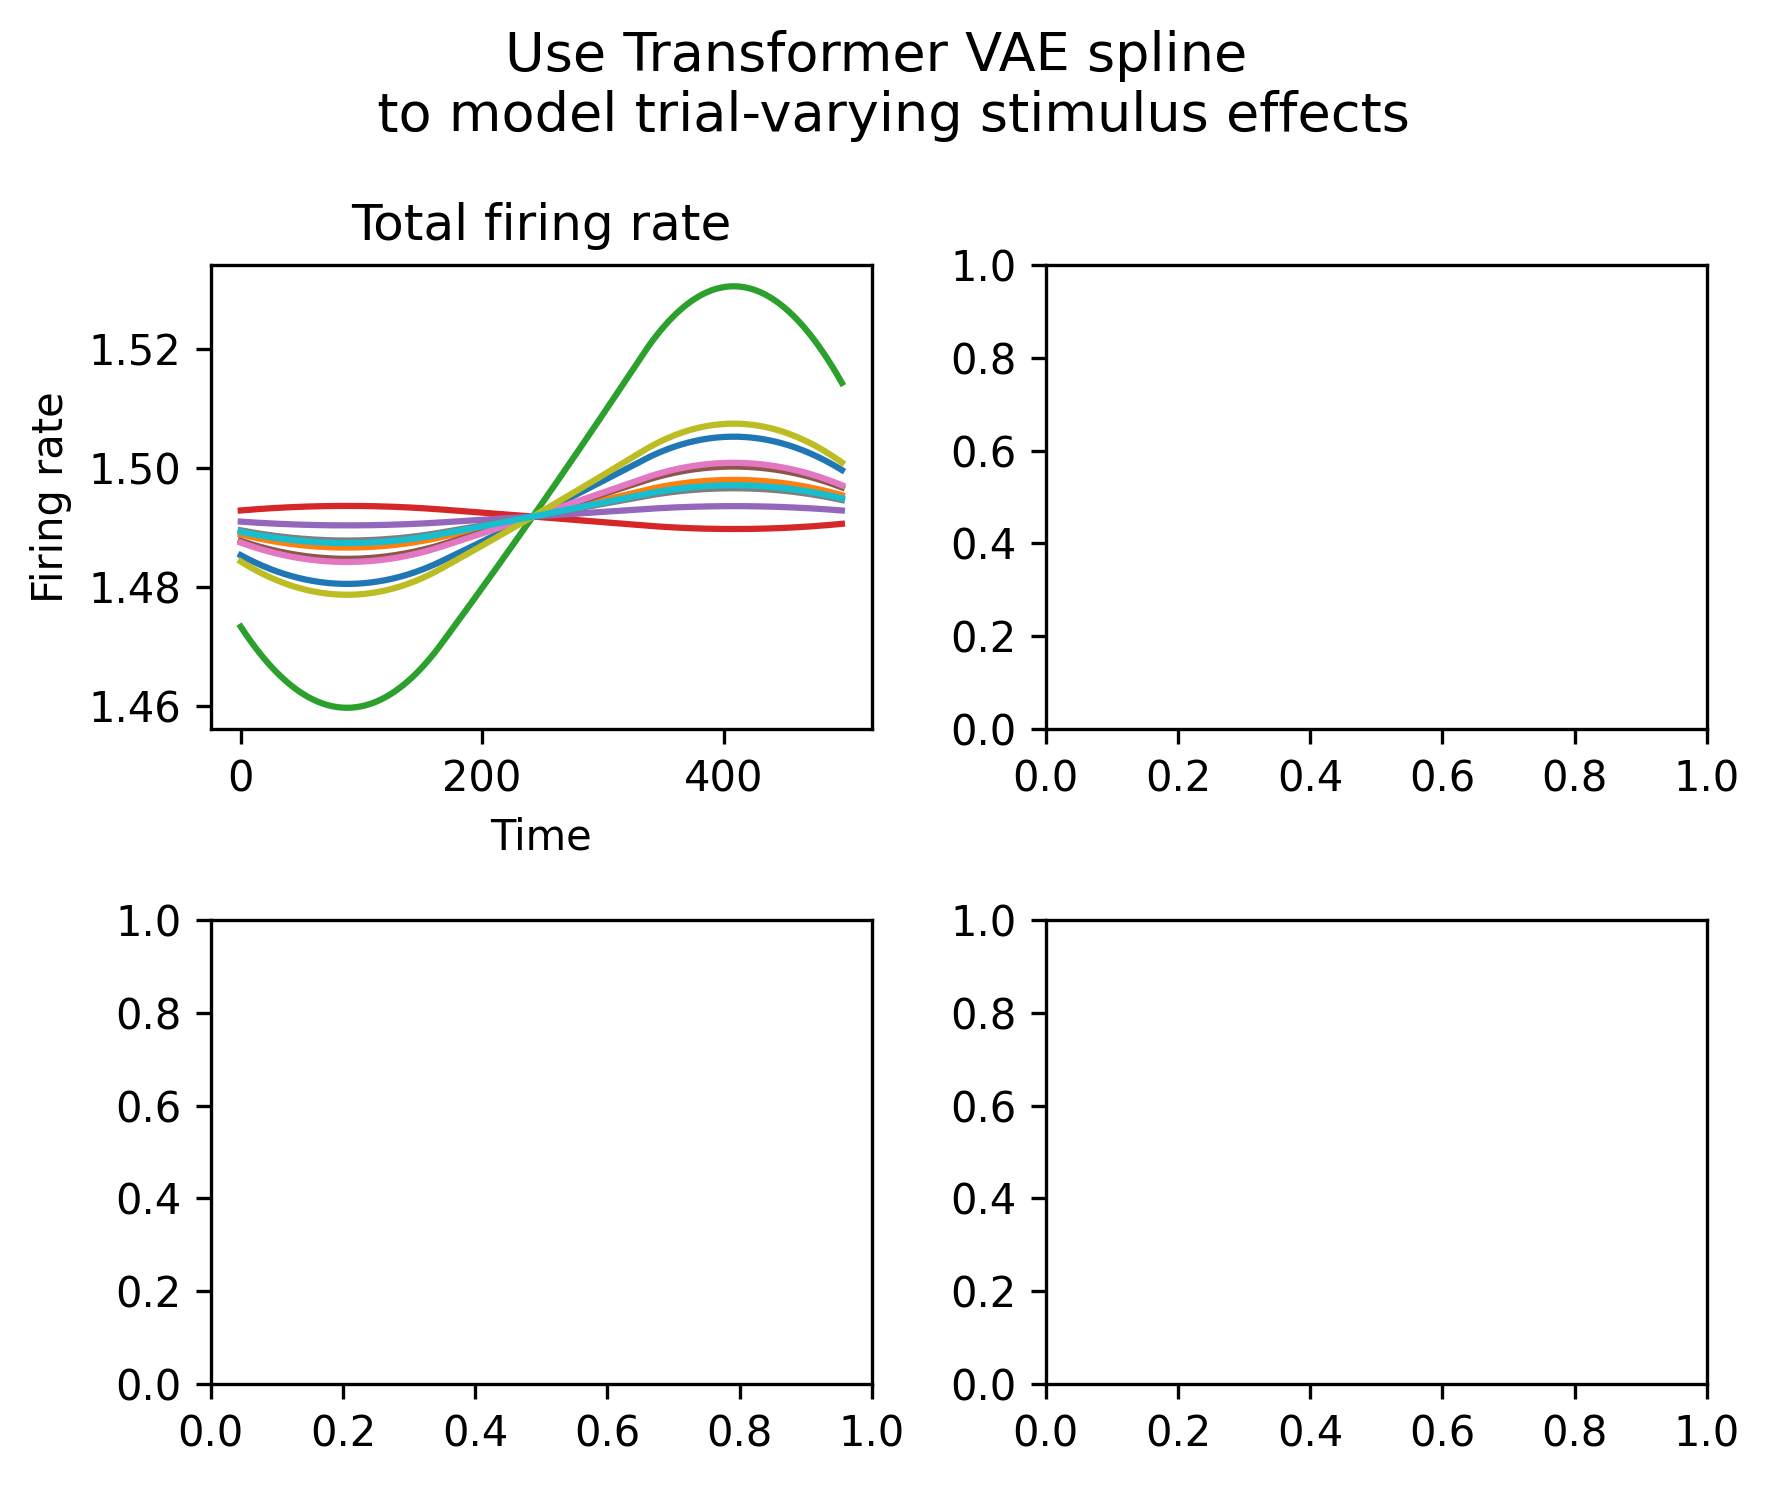

In [102]:
trial_indices = 18
neuron_idx = np.arange(0, 10)

firing_rate_test, sti_mu_test, sti_logvar_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    return_torch=True, 
    include_stimulus=True,
    include_coupling=False, 
    fix_stimulus=True,
    fix_latents=True, 
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5) ,dpi=300)
fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Plot total firing rate
xx = np.arange(0, 500, 2)
axes[0,0].plot(xx, np.exp(firing_rate_test[:, neuron_idx, trial_indices].numpy()))
# axes[0,0].plot(xx, firing_rate_test[:, neuron_idx, trial_indices].numpy())
axes[0,0].set_title('Total firing rate')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Firing rate')
# axes[0,0].legend([f'Trial {i+1}' for i in range(trainer.model.firing_rates_stimulus.shape[2])], 
#                  bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# Plot coupling effect
# axes[0,1].plot(trainer.model.firing_rates_coupling[:, neuron_idx, trial_indices].cpu().numpy().T)
# axes[0,1].set_title('Coupling Effect')
# axes[0,1].set_xlabel('Time')
# axes[0,1].set_ylabel('log firing rate')

# Plot stimulus effect
# axes[1,0].plot(trainer.model.firing_rates_stimulus[:, neuron_idx, trial_indices].cpu().numpy().T)
# axes[1,0].set_title('Stimulus Effect')
# axes[1,0].set_xlabel('Time')
# axes[1,0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
# tsne = TSNE(n_components=2, random_state=42)
# sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
# sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
# axes[1,1].scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.5, marker='.')
# axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
# axes[1,1].set_xlabel('t-SNE 1')
# axes[1,1].set_ylabel('t-SNE 2')

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne0.pdf', bbox_inches='tight', dpi=300)